# **Modelamiento de datos SEV y SEDT**

Autores

- **Daniela Quintero**: [yejoandajudi200305@gmail.com](mailto:yejoandajudi200305@gmail.com)
- **Paul Goyes**: [goyes.yesid@gmail.com](mailto:goyes.yesid@gmail.com)  

Importar las librerías necesarias

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Pygimli
import pygimli as pg
from pygimli.physics.em import rhoafromU
from pygimli.physics.em import VMDTimeDomainModelling
from pygimli.viewer.mpl import drawModel1D

# SimPEG
from simpeg import maps
from simpeg.electromagnetics.static import resistivity as dc
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model

mpl.rcParams.update({"font.size": 16})

write_output = False

# Modelamiento SEV

## Arreglo

In [2]:
# Arreglo tipo schlumberger

# Definir el espaciado de ab2 y número de sondeos
ab2= np.logspace(np.log10(2),np.log10(700),25) # Desde 1.5 metros a 200 metros

# Crear lista de las fuentes
source_list = []
for ii in range(0, len(ab2)):
    abb2 = ab2[ii]

    # Ubicación de los electrodos A y B
    A_location = np.r_[-abb2, 0.0, 0.0]
    B_location = np.r_[abb2, 0.0, 0.0]

    # Ubicación de los electrodos M y N
    M_location = np.r_[-abb2/3, 0.0, 0.0]
    N_location = np.r_[abb2/3, 0.0, 0.0]

    # Crear lista de receptores
    receiver_list = dc.receivers.Dipole(
        M_location, N_location, data_type="apparent_resistivity"
    )
    receiver_list = [receiver_list]

    # Definir las propiedades de las fuentes y receptores asociados
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Definir el arreglo
surveySEV = dc.Survey(source_list)

In [3]:
print("# of locations: {}".format(surveySEV.nSrc))  # number of sources
print("# of data: {}".format(surveySEV.nD))  # number of data that will be simulated
print(surveySEV.source_list[0])  # the 3rd source object
print(surveySEV.source_list[0].receiver_list[0])  # Its receiver

# of locations: 25
# of data: 25
Dipole(a: [-2.  0.  0.]; b: [2. 0. 0.])
Dipole(m: [-0.66666667  0.          0.        ]; n: [0.66666667 0.         0.        ])


## Modelo sintético del subsuelo

In [4]:
# Modelo hidrogeológico

# Definir espesores de las capas
thicknesses = np.r_[7, 75, 130]

# Definir resistividades de las capas
model = np.r_[200, 13, 1400, 70]

# Número de capas
n_layers = len(model)

# Definir mapeo del modelo de conductividad
resistivity_model = model.copy()
model_map = maps.IdentityMap(nP=n_layers)

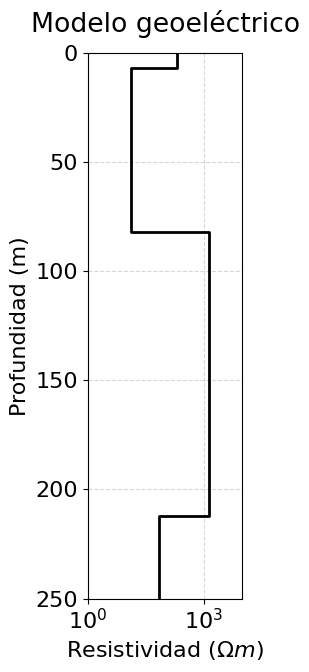

In [5]:
# Graficar el modelo
fig, ax = plt.subplots(figsize=(3, 7))
ax = plot_1d_layer_model(thicknesses, model_map * model, ax=ax, color="black", label="Modelo teórico", lw= 2)
ax.set_xlabel(r"Resistividad ($\Omega m$)")
ax.set_ylabel(r"Profundidad (m)")
#ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
ax.set_ylim(250, 0)
ax.set_xlim([10**0, 10**4])
ax.set_title("Modelo geoeléctrico", pad=15)
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.tight_layout()

filename = "ModeloHidroeléctrico.svg"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='svg')

## Simulación

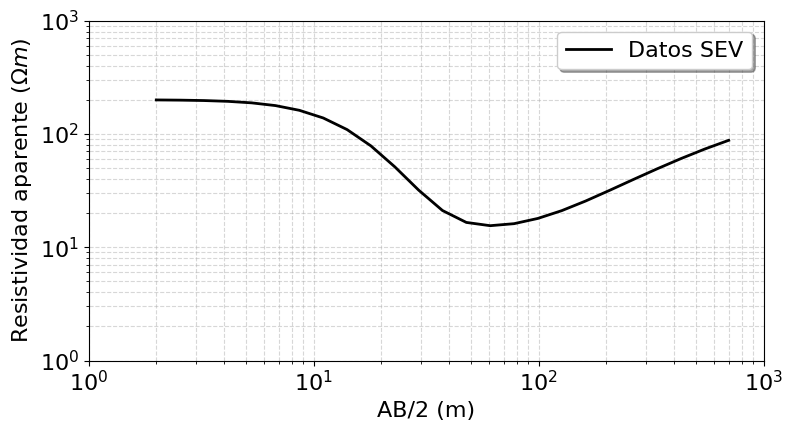

In [6]:
simulationSEV = dc.simulation_1d.Simulation1DLayers(
    survey=surveySEV,
    rhoMap=model_map,
    thicknesses=thicknesses,
)

dpredSEV = simulationSEV.dpred(model)

# Graficar la curva de resistividad aparente
fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax1.loglog(ab2, dpredSEV, color="black", label="Datos SEV", lw= 2)
ax1.set_xlabel("AB/2 (m)")
ax1.set_ylabel(r"Resistividad aparente ($\Omega m$)")
ax1.set_ylim([10**0, 10**3])
ax1.set_xlim([10**0, 10**3])
ax1.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)

#plt.tight_layout()

filename = "DatosSEV.svg"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='svg')
plt.show()

In [7]:
# Crear un diccionario con los datos
DatosSEV = {"dpredSEV": dpredSEV, "ab2": ab2}

# Guardar en un solo archivo .npy
np.save("DatosSEV", DatosSEV)

# Modelamiento TDEM | Simpeg

## Arreglo

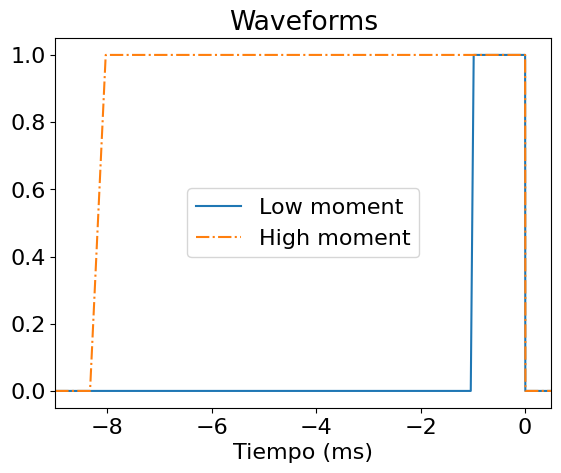

In [8]:
# Definir waveform

# Low moment
lm_waveform_times = np.r_[-1.041E-03, -9.850E-04, 0.000E+00, 4.000E-06]
lm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

# High moment
hm_waveform_times = np.r_[-8.333E-03, -8.033E-03, 0.000E+00, 5.600E-06]
hm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

plt.figure()
plt.title('Waveforms')
plt.plot(np.r_[-9, lm_waveform_times*1e3, 2], np.r_[0, lm_waveform_current, 0],
         label='Low moment')
plt.plot(np.r_[-9, hm_waveform_times*1e3, 2], np.r_[0, hm_waveform_current, 0],
         '-.', label='High moment')
plt.xlabel('Tiempo (ms)')
plt.xlim([-9, 0.5])
plt.legend()
plt.show()

waveform_LM = tdem.sources.PiecewiseLinearWaveform(
    times=lm_waveform_times, currents=lm_waveform_current
)

waveform_HM = tdem.sources.PiecewiseLinearWaveform(
    times=hm_waveform_times, currents=hm_waveform_current
)

In [9]:
# Receptores

receiver_location = np.array([0, 0, 0])
receiver_orientation = "z"  # "x", "y" or "z"

times = np.logspace(-4,-1,25)

receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times, orientation=receiver_orientation
    )
)

# Fuente

source_location = np.array([
    [-20, -20, 0],        # Vértice 1 (punto de inicio)
    [20, -20, 0],     # Vértice 2
    [20, 20, 0],  # Vértice 3
    [-20, 20, 0],     # Vértice 4
    [-20, -20, 0]         # Cerrar el bucle (vuelve al punto de inicio)
])

source_list = [tdem.sources.LineCurrent(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform_HM,),

        tdem.sources.LineCurrent(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform_LM,)
]

# Definir el arreglo
surveyTDEM = tdem.Survey(source_list)

## Simulación

In [10]:
simulationTDEM = tdem.simulation_1d.Simulation1DLayered(
    survey=surveyTDEM,
    rhoMap=model_map,
    thicknesses=thicknesses,
)

In [11]:
dpredTDEM = simulationTDEM.dpred(resistivity_model)
dpredTDEM.shape

(50,)

In [12]:
times.shape

(25,)

In [13]:
dpred_LM = dpredTDEM[25:]
dpred_HM = dpredTDEM[:25]

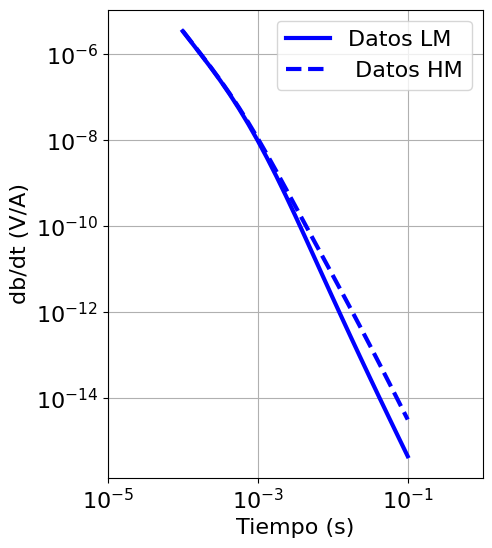

In [14]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times, -dpred_LM, "b-", lw=3, label='Datos LM')
ax.loglog(times, -dpred_HM, "b--", lw=3, label=' Datos HM')

ax.set_xlim([times.min()/10, 10*times.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("db/dt (V/A)")
#ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [15]:
# Crear un diccionario con los datos
DatosSEDT_2 = {"dobsTDEM": dpredTDEM, "times": times}

# Guardar en un solo archivo .npy
np.save("DatosSEDTdbdt", DatosSEDT_2)

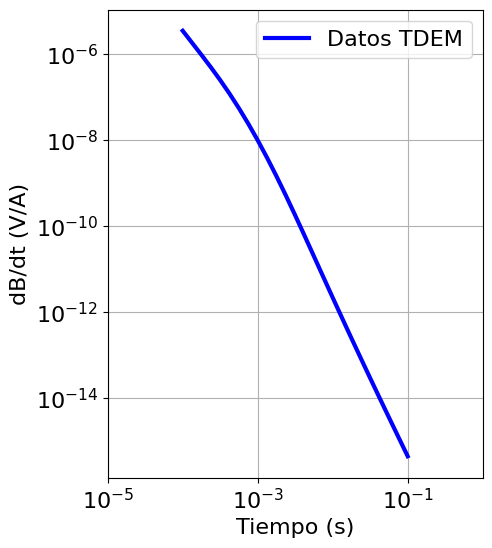

In [16]:
from scipy import interpolate
x = np.concatenate((times, times))
y = np.concatenate((-dpred_HM, -dpred_LM))
f = interpolate.interp1d(x, y)

times_ok = np.logspace(np.log10(np.min(times)),np.log10(np.max(times)),25)
dpredTDEM_ok = f(times_ok)   # use interpolation function returned by `interp1d`



fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times_ok, dpredTDEM_ok, "b-", lw=3, label='Datos TDEM')
#ax.loglog(xnew, ynew, "r--", lw=3, label='dpred_HM')
#ax.loglog(time_LM, dobs_LM, "b.",  label='dobs_LM')
#ax.loglog(time_HM, dobs_HM, "r.", label='dobs_HM')

ax.set_xlim([times.min()/10, 10*times.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("dB/dt (V/A)")
#ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [17]:
times_ok.shape

(25,)

In [18]:
dpredTDEM_ok.shape

(25,)

In [19]:
rhoa_TDEM = rhoafromU(U= dpredTDEM_ok, t= times_ok, Tx= 1600, Rx= 1)

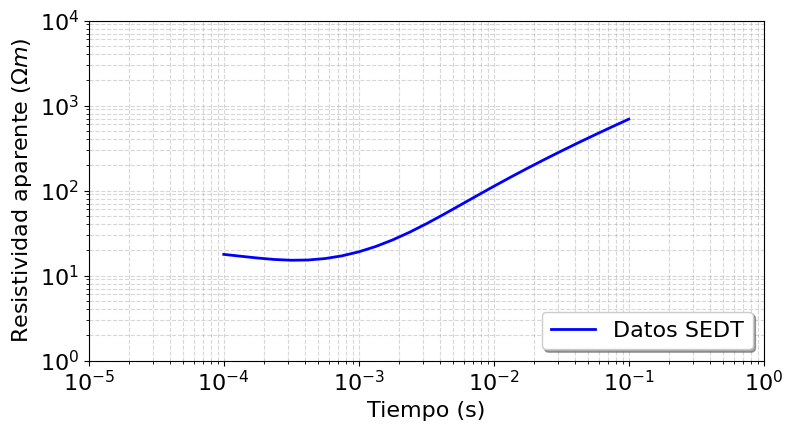

In [20]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax.loglog(times_ok, rhoa_TDEM, "b-", lw=2, label='Datos SEDT')
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**0, 10**4])
ax.set_xlim([10**-5, 10**0])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)

#plt.tight_layout()

filename = "DatosSEDT.svg"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='svg')
plt.show()

In [21]:
# Crear un diccionario con los datos
DatosSEDT = {"dobsTDEM": rhoa_TDEM, "times": times_ok}

# Guardar en un solo archivo .npy
np.save("DatosSEDTrhoa", DatosSEDT)

# Desplazamiento estático

In [22]:
# Convertir de tiempo a ab2
L = 711.8 * np.sqrt(times_ok * rhoa_TDEM)

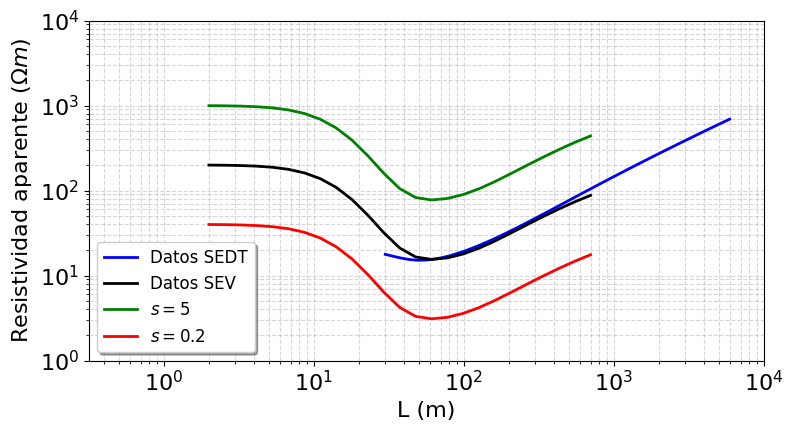

In [23]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax.loglog(L, rhoa_TDEM, "blue",  label='Datos SEDT', lw=2)
ax.loglog(ab2, dpredSEV, "black", label='Datos SEV', lw=2)
ax.loglog(ab2, (5*dpredSEV), "green", label='$\mathit{s}=5$', lw=2)
ax.loglog(ab2, (1/5*dpredSEV), "red", label='$\mathit{s}=0.2$', lw=2)

ax.set_xlabel("L (m)")
ax.set_ylabel("Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**0, 10**4])
ax.set_xlim([10**-0.5, 10**4])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower left', frameon=True, shadow=True, fancybox=True, fontsize=12)

#plt.tight_layout()

filename = "staticshift.svg"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='svg')
plt.show()

# Modelamiento TDEM | Pygimli

In [24]:
h = thicknesses.tolist()
print(h)

l = model.tolist()
print(l)

[7, 75, 130]
[200, 13, 1400, 70]


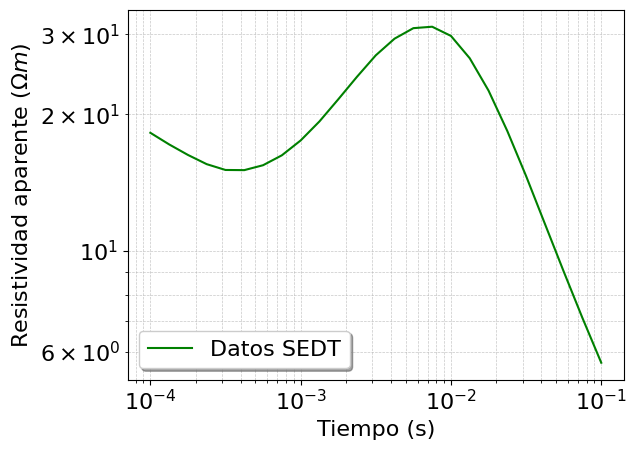

In [25]:
#Modelado directo del método SEDT
errorEMabs = 0.05
times = np.logspace(-4,-1,25)
TDEM = VMDTimeDomainModelling(times=times, txArea=1600, rxArea=200,nLayers=n_layers)
dataTDEM = pg.Vector( TDEM(h+l))

errorTDEM = np.ones_like(dataTDEM) * errorEMabs / 100.
dataTDEM *= 1. + pg.randn(len(dataTDEM), seed=1234) * errorTDEM
dataTDEM
plt.loglog(times,dataTDEM, color="green", label="Datos SEDT")
plt.xlabel("Tiempo (s)")
plt.ylabel("Resistividad aparente ($\Omega m$)")
plt.legend(loc="lower left", frameon=True, shadow=True)
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

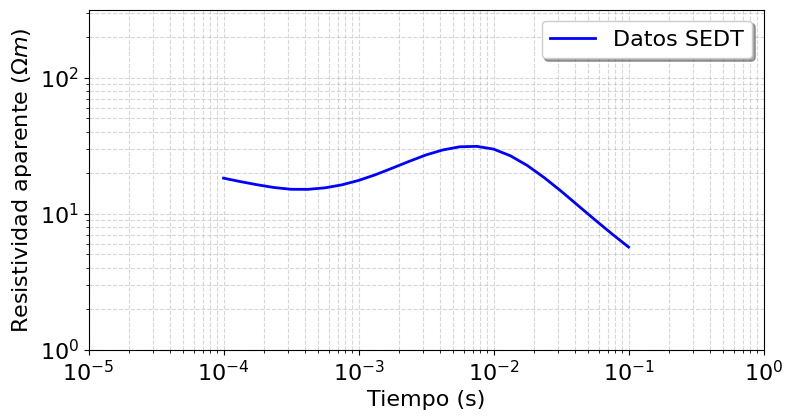

In [26]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax.loglog(times, dataTDEM, "b-", lw=2, label='Datos SEDT')
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**0, 10**2.5])
ax.set_xlim([10**-5, 10**0])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)

#plt.tight_layout()

#filename = "DatosSEDT.png"
#plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')
plt.show()

In [27]:
# Convertir de tiempo a ab2
L = 711.8 * np.sqrt(times_ok * rhoa_TDEM)

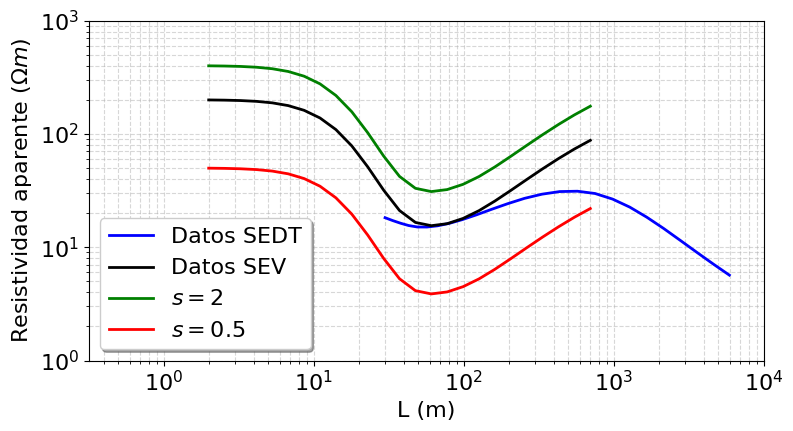

In [28]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])

ax.loglog(L, dataTDEM, "blue",  label='Datos SEDT', lw=2)
ax.loglog(ab2, dpredSEV, "black", label='Datos SEV', lw=2)
ax.loglog(ab2, (2*dpredSEV), "green", label='$\mathit{s}=2$', lw=2)
ax.loglog(ab2, (1/4*dpredSEV), "red", label='$\mathit{s}=0.5$', lw=2)

ax.set_xlabel("L (m)")
ax.set_ylabel("Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**0, 10**3])
ax.set_xlim([10**-0.5, 10**4])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower left', frameon=True, shadow=True, fancybox=True)

#plt.tight_layout()

#filename = "staticshift.png"
#plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')
plt.show()